#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.

# Updating to work on counting all metabolites
## address comment on BIOS-SCOPE four years paper
### KL 8/3/2023

In [86]:
#the -f does the reset without requiring user confirmations
%reset -f

In [87]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb
from sklearn import preprocessing
import seaborn as sns

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

from scipy.cluster import hierarchy as hc

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [88]:
mtabFile = 'BIOSSCOPE_metabolites_complete.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabNames = pd.read_csv(mtabFile,index_col = 'KEGG',usecols = ['KEGG','mtabNames'])
mtabNames.head(3)

,mtabNames
KEGG,
C00196,2-3-dihydroxybenzoic acid
C19675,2-3-dihydroxypropane1sulfonate
C08276,3-mercapto proprionate


In [119]:
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
#compounds without KEGG numbers are: acetyltaurine, chitotriose
#also remember that we have compounds with isomers, but only listing one KEGG number
mtabPruned = mtabData.drop(['0'])

Setup a few useful functions
---

In [90]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [91]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [92]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [93]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] != '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [94]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimMap(importString):
    export_trimMap = []
    current_section = None
    for line in importString.rstrip().split("\n"):
        r = line.find('map')
        tp = line[r : r+9]
        export_trimMap.append(tp)
    return export_trimMap

#trim a pathway/compound list
def trimCompounds(cpdString):
    export_trimCpds = []
    current_section = None
    for line in cpdString.rstrip().split("\n"):
        #print(line)
        r = line.find('cpd')
        tp = line[r + 4 : len(line)]
        export_trimCpds.append(tp)
    return export_trimCpds

#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

In [95]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head(3)

,map,A,B,C,wholeThing
5,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n
6,01110,Metabolism,Global and overview maps,Biosynthesis of secondary metabolites,C 01110 Biosynthesis of secondary metaboli...
7,01120,Metabolism,Global and overview maps,Microbial metabolism in diverse environments,C 01120 Microbial metabolism in diverse en...


In [96]:
prunedBRITE[prunedBRITE.loc[:,'map']=='00410'] #check one

,map,A,B,C,wholeThing
77,00410,Metabolism,Metabolism of other amino acids,beta-Alanine metabolism,C 00410 beta-Alanine metabolism\n


In [97]:
#only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [98]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [99]:
pathwayInfo = pd.DataFrame({'pGroup' : unMetabolismGroups,'nCpds' : np.nan,'nMeasure': np.nan})

In [100]:
useCO = mtabPruned.index
ProData= set(useCO)

for oneGroup in unMetabolismGroups:
    shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)]
    onePath = shortList.loc[:,'map']
    onePath_ann=[]

    gatherAll = list()
    gatherPro = pd.DataFrame()
    
    for item in onePath:
        #onePath_ann.append('ko' + item)
        usePathway = 'ko' + item
        try:
            mCpds = set(getCfrom_ko(usePathway))
        except:
            print('invalid pathway at KEGG: ' + usePathway)

        #first, gather all compounds...
        for cpd in mCpds:
            if (cpd in gatherAll): #don't add to list if already there
                pass
            else:
                gatherAll.append(cpd)

        #now only count the ones in Pro
        handh = mCpds.intersection(ProData)
        for cpd in handh:
            tm = mtabPruned.loc[cpd,:]
            if (cpd in gatherPro.index): 
                pass
            else: #only add the mtab if it is new...can have mtabs in multiple pathways
                gatherPro = gatherPro.append(tm)

    pathwayInfo.loc[(pathwayInfo['pGroup']==oneGroup),'nCpds'] = len(gatherAll)
    pathwayInfo.loc[(pathwayInfo['pGroup']==oneGroup),'nMeasure'] = len(gatherPro)
    
    #export the list of compounds in each group for MATLAB
    eDF = pd.DataFrame(gatherPro)
    eDF.to_csv('compoundList_' + oneGroup + '.csv')

invalid pathway at KEGG: ko01010
invalid pathway at KEGG: ko01060
invalid pathway at KEGG: ko01061
invalid pathway at KEGG: ko01062
invalid pathway at KEGG: ko01063
invalid pathway at KEGG: ko01064
invalid pathway at KEGG: ko01065
invalid pathway at KEGG: ko01066
invalid pathway at KEGG: ko01070


Consider how prevalent each compound is within KEGG
---

In [101]:
#adapt the code to count the compounds in the TSQ data set

In [191]:
#this seems inefficient - but I have to reset the index, copy the KEGG column to a new column, and then make an
#index that is numbers
countReactions = mtabPruned.copy(deep=True)
countReactions.reset_index()
countReactions['KEGG'] = countReactions.index #copy KEGG column data to new column
nr =len(countReactions)
index = pd.Index(range(0,nr,1)) #range is start,stop,step
countReactions = countReactions.set_index(index,drop=False)
countReactions

,mtabNames,KEGG
0,2-3-dihydroxybenzoic acid,C00196
1,2-3-dihydroxypropane1sulfonate,C19675
2,3-mercapto proprionate,C08276
3,3-methyl-2-oxobutanoic acid,C00141
4,3-methyl-2-oxopentanoic acid,C00671
...,...,...
89,uracil pos,C00106
90,uridine 5-monophosphate pos,C00105
91,valine,C00183
92,xanthine pos,C00385


In [192]:
#was countReactions.ix which has now (a/o 2022) been removed entirely; change to countReactions.loc
for idx in range(0,len(countReactions)):
    oneCpd = countReactions.loc[idx,'KEGG']
    rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
    countReactions.loc[idx,'nReactions'] = len(rnList.splitlines())
    
    #now go count the pathways
    rnList = kegg_link('pathway',oneCpd).read()
    countReactions.loc[idx,'nPathways'] = len(rnList.splitlines())

In [193]:
countReactions.sort_values(by = 'nReactions',ascending = False,inplace = True)
countReactions.reset_index(drop=True,inplace = True)
countReactions.head(4)

,mtabNames,KEGG,nReactions,nPathways
0,NAD pos,C00004,1005.0,5.0
1,s-adenosyl-L-methionine,C00019,517.0,13.0
2,s-(5'-adenosyl)-L-homocysteine pos,C00021,457.0,5.0
3,adenosine 5'-monophosphate pos,C00020,310.0,28.0


In [194]:
#investigate one compound
oneCpd = 'C00004'

In [195]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('pathway',oneCpd).read() #now go get the compounds for that reaction
print(len(rnList.splitlines()))

5


In [196]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
print(len(rnList.splitlines()))

1005


In [197]:
#pantothenic acid is C00864
countReactions.loc[countReactions['KEGG']=='C00864']

,mtabNames,KEGG,nReactions,nPathways
66,pantothenic acid neg,C00864,7.0,6.0


In [198]:
#make an abbreviated dataset for plotting: top ten compounds
use = range(0,10)
labels = countReactions.loc[use,'KEGG']
tData = countReactions.loc[use]

In [199]:
tData

,mtabNames,KEGG,nReactions,nPathways
0,NAD pos,C00004,1005.0,5.0
1,s-adenosyl-L-methionine,C00019,517.0,13.0
2,s-(5'-adenosyl)-L-homocysteine pos,C00021,457.0,5.0
3,adenosine 5'-monophosphate pos,C00020,310.0,28.0
4,alpha-ketoglutaric acid,C00026,297.0,39.0
5,glutamic acid,C00025,212.0,52.0
6,succinic acid,C00042,191.0,32.0
7,l-glutathione,C00051,95.0,10.0
8,methionine,C00073,80.0,16.0
9,l-cysteine,C00097,50.0,23.0


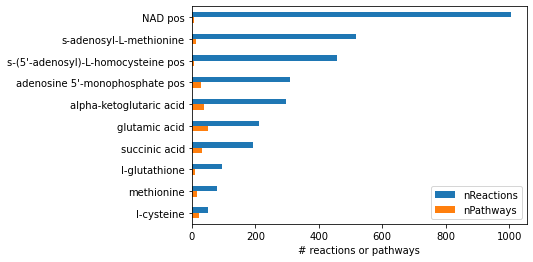

In [200]:
#ax = tData.plot(kind = 'barh',x = tData['KEGG'])
#axs = tData.plot(kind = 'barh',x = mtabNames.loc[tData.loc[:,'KEGG'],'mtabNames'])
axs = tData.plot(kind = 'barh')
axs.set_yticklabels(mtabNames.loc[tData.loc[:,'KEGG'],'mtabNames'])
axs.set_xlabel('# reactions or pathways')
axs.invert_yaxis()
plt.savefig('metabolites_topTen.pdf',bbox_inches='tight')

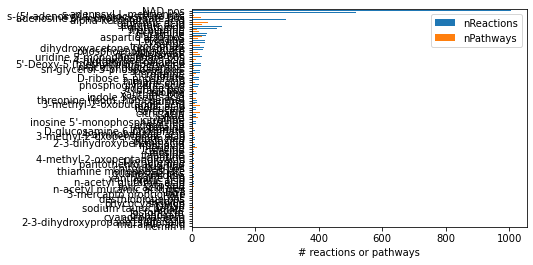

In [201]:
#or go nuts and plot the whole thing
use = range(0,nr)
labels = countReactions.loc[use,'KEGG']
tData = countReactions.loc[use]

axs = tData.plot(kind = 'barh')
axs.set_yticklabels(mtabNames.loc[tData.loc[:,'KEGG'],'mtabNames'])
axs.set_xlabel('# reactions or pathways')
axs.invert_yaxis()
plt.savefig('metabolites_topTen.pdf',bbox_inches='tight')